In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import block_diag

np.set_printoptions(precision=3, suppress=True)

In [2]:
n = 7
coeffs = np.random.rand(n+1) * 10
p = 4
eval_tf = np.random.rand()
eval_t0 = np.random.uniform(0, eval_tf)

H = np.zeros((n + 1, n + 1))

for i in range(p, n + 1):
    for j in range(p, n + 1):
        new_i = n - i
        new_j = n - j
        
        H[new_i, new_j] = math.factorial(i) * math.factorial(j) / (math.factorial(i - p) * math.factorial(j - p)) * \
                          (1 / (i + j - 2 * p + 1)) * \
                          (eval_tf ** (i + j - 2 * p + 1) - eval_t0 ** (i + j - 2 * p + 1))

est_val = np.dot(np.dot(coeffs, H), coeffs)

true_val = np.polyder(coeffs, m=p)
true_val = np.polymul(true_val, true_val)
true_val = np.polyint(true_val)

true_val = np.polyval(true_val, eval_tf) - np.polyval(true_val, eval_t0)

print(est_val)
print(true_val)
print(H)

550155.6840552738
550155.6840552738
[[5062.935 3881.038 2379.909  911.795    0.       0.       0.       0.   ]
 [3881.038 3059.883 1953.846  796.546    0.       0.       0.       0.   ]
 [2379.909 1953.846 1327.576  599.012    0.       0.       0.       0.   ]
 [ 911.795  796.546  599.012  319.672    0.       0.       0.       0.   ]
 [   0.       0.       0.       0.       0.       0.       0.       0.   ]
 [   0.       0.       0.       0.       0.       0.       0.       0.   ]
 [   0.       0.       0.       0.       0.       0.       0.       0.   ]
 [   0.       0.       0.       0.       0.       0.       0.       0.   ]]


In [3]:
waypoints = np.array([
    0.0,
    2.0,
    10.0,
    5.0,
], dtype=np.float64)

times = np.array([
    1.0,
    2.0,
    3.0,
    4.0
], dtype=np.float64)

t0, tf = times[0], times[-1]
w0, wf = waypoints[0], waypoints[-1]

N = 7 # degree of polynomial
M = len(waypoints) - 1  # number of segments
p = 4  # degree of derivative to minimize

polyderivs = [
    np.polyder(np.ones(N+1), m=i) for i in range(1, N + 1)
]

n_constrained_end_derivs = 2
n_constraints = 2 * M + \
                M - 1 + \
                2 * n_constrained_end_derivs

def seg_indices(segment_index, m=0):
    return segment_index * (N + 1), (segment_index + 1) * (N + 1) - m 

In [4]:
H_array = [np.zeros(shape=(N + 1, N + 1), dtype=np.float64) for _ in range(M)]
factorials = [math.factorial(i) for i in range(N + 1)]

for k in range(M):
    H = H_array[k]
    seg_t0, seg_tf = times[k], times[k+1]
    
    for i in range(p, N + 1):
        for j in range(p, N + 1):
            new_i = N - i
            new_j = N - j
            
            exponent = i + j - 2 * p + 1
            
            H[new_i, new_j] = factorials[i] * factorials[j] / (factorials[i - p] * factorials[j - p]) * \
                              1 / exponent * \
                              (seg_tf ** exponent - seg_t0 ** exponent)

H = block_diag(*H_array)

In [5]:
A = np.zeros(shape=(n_constraints, (N + 1) * M))
b = np.zeros(shape=(n_constraints,))

# Endpoint waypoint constraints
row_index = 0

for i in range(M):
    seg_t0, seg_tf = times[i], times[i+1]
    seg_w0, seg_wf = waypoints[i], waypoints[i+1]
    
    A_col_idx0, A_col_idxf = seg_indices(i, m=0)
    
    t0_coeffs = seg_t0 ** np.arange(N, -1, -1)
    tf_coeffs = seg_tf ** np.arange(N, -1, -1)
    
    A[row_index,     A_col_idx0 : A_col_idxf] = t0_coeffs
    b[row_index]     = seg_w0
    row_index += 1
    
    A[row_index, A_col_idx0 : A_col_idxf] = tf_coeffs
    b[row_index] = seg_wf
    row_index += 1
    
# Intermediate segment first derivative continuity constraint

for i in range(M - 1):
    seg_curr_tf, seg_next_t0 = times[i+1], times[i+1]

    A_seg_curr_col_idx0, A_seg_curr_col_idxf = seg_indices(i, m=1)
    A_seg_next_col_idx0, A_seg_next_col_idxf = seg_indices(i+1, m=1)
    
    poly_deriv_1_coeffs = polyderivs[0]
    seg_curr_tf_deriv_coeffs = poly_deriv_1_coeffs * (seg_curr_tf ** np.arange(N - 1, -1, -1))
    seg_next_t0_deriv_coeffs = poly_deriv_1_coeffs * (seg_next_t0 ** np.arange(N - 1, -1, -1))
    
    A[row_index, A_seg_curr_col_idx0 : A_seg_curr_col_idxf] = seg_curr_tf_deriv_coeffs
    A[row_index, A_seg_next_col_idx0 : A_seg_next_col_idxf] = -seg_next_t0_deriv_coeffs
    row_index += 1
    
# First and last segment start/end must have zero-value derivatives

for i, t in enumerate([t0, tf]):
    seg_index = 0 if i == 0 else M - 1
    
    for deriv_order in range(1, n_constrained_end_derivs + 1):
        A_curr_col_idx0, A_curr_col_idxf = seg_indices(seg_index, m=deriv_order)

        poly_deriv_order_coeffs = polyderivs[deriv_order - 1]
        t_deriv_coeffs = poly_deriv_order_coeffs * (t ** np.arange(N - deriv_order, -1, -1))
                
        A[row_index, A_curr_col_idx0 : A_curr_col_idxf] = t_deriv_coeffs
        row_index += 1
        
# # Solve for coefficients
# x, _residual, _, _ = np.linalg.lstsq(A, b)

In [6]:
# Solve min snap optimization problem
x = cp.Variable((N + 1) * M)
prob = cp.Problem(cp.Minimize(cp.quad_form(x, H, assume_PSD=True)),
                 [A @ x == b])
prob.solve(solver='SCS')

1.0181732568406686e-17

[  -0.    0.   -0.    0.    2.   -6.    6.   -2.    0.   -0.    0.   -0.
  -25.  177. -402.  298.   -0.    0.   -0.    0.   -5.   60. -240.  325.]


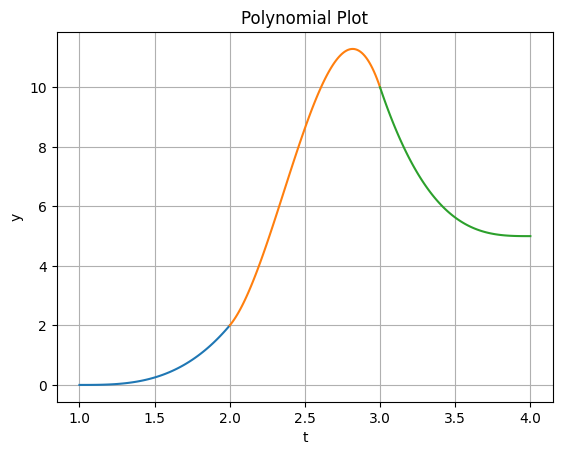

In [7]:
sol_val = x.value
print(sol_val)
ts_agg = []
ys_agg = []

for m in range(M):
    ts = np.linspace(times[m], times[m+1], 100)
    
    s = m * (N + 1)
    e = s + (N + 1)
    
    coeffs = sol_val[s:e]

    ys = np.polyval(coeffs, ts)
    
    ts_agg.append(ts)
    ys_agg.append(ys)

for ts, ys in zip(ts_agg, ys_agg):
    plt.plot(ts, ys)

# Plot the polynomial
plt.title('Polynomial Plot')
plt.xlabel('t')
plt.ylabel('y')
plt.grid(True)
plt.show()  

[    -0.         0.        -0.         0.        19.712    -76.847
     94.559    -37.424      0.        -0.         0.        -0.
    -13.003     75.311   -121.493     47.768     -1.471     33.97
   -331.87    1778.881  -5667.443  10813.484 -11616.169   5565.224]


/Users/micahreich/Documents/uav_control/pyenv/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


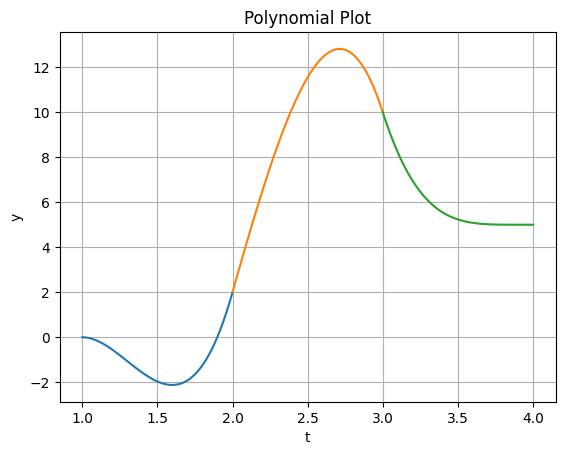

In [8]:
from uav_control.planners.polynomial_trajgen import traj_opt_1d

sol_val = traj_opt_1d(waypoints, times, order=7, n_constrained_end_derivs=2, minimize_order=4)
print(sol_val)
ts_agg = []
ys_agg = []

for m in range(M):
    ts = np.linspace(times[m], times[m+1], 100)
    
    s = m * (N + 1)
    e = s + (N + 1)
    
    coeffs = sol_val[s:e]

    ys = np.polyval(coeffs, ts)
    
    ts_agg.append(ts)
    ys_agg.append(ys)

for ts, ys in zip(ts_agg, ys_agg):
    plt.plot(ts, ys)

# Plot the polynomial
plt.title('Polynomial Plot')
plt.xlabel('t')
plt.ylabel('y')
plt.grid(True)
plt.show()  

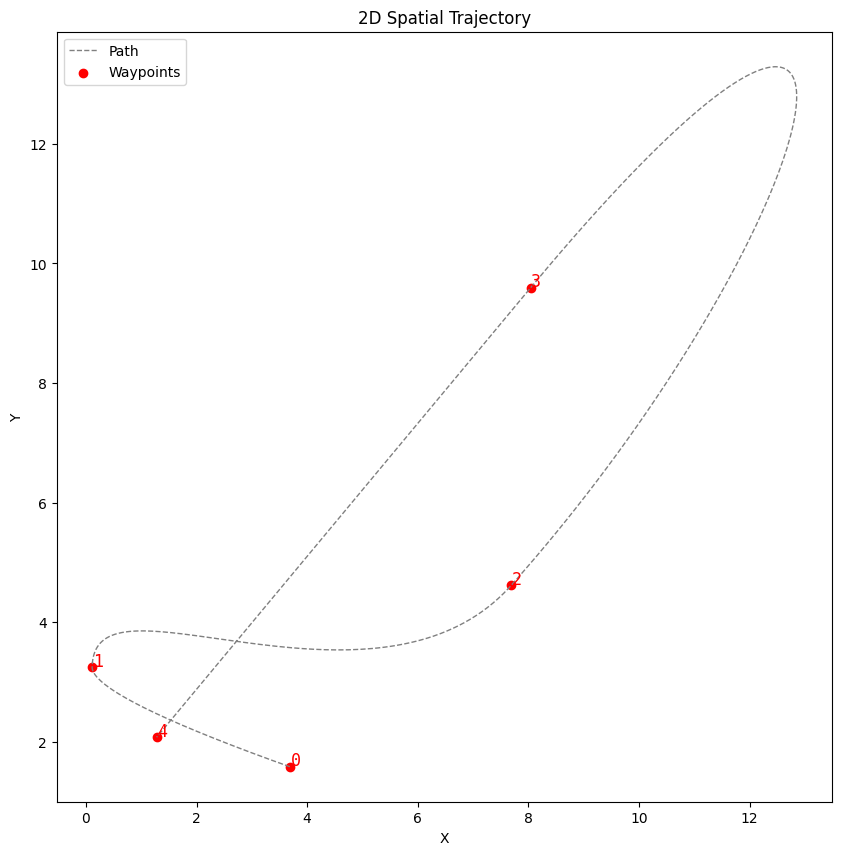

In [9]:
from uav_control.planners.polynomial_trajgen import PolynomialTrajectoryND, visualize_spatial_trajectory

n_points = 5
times = np.arange(n_points, dtype=np.float64)
waypoints = np.random.rand(n_points, 2) * 10

traj = PolynomialTrajectoryND(waypoints, times)
fig = visualize_spatial_trajectory(traj)
plt.show()

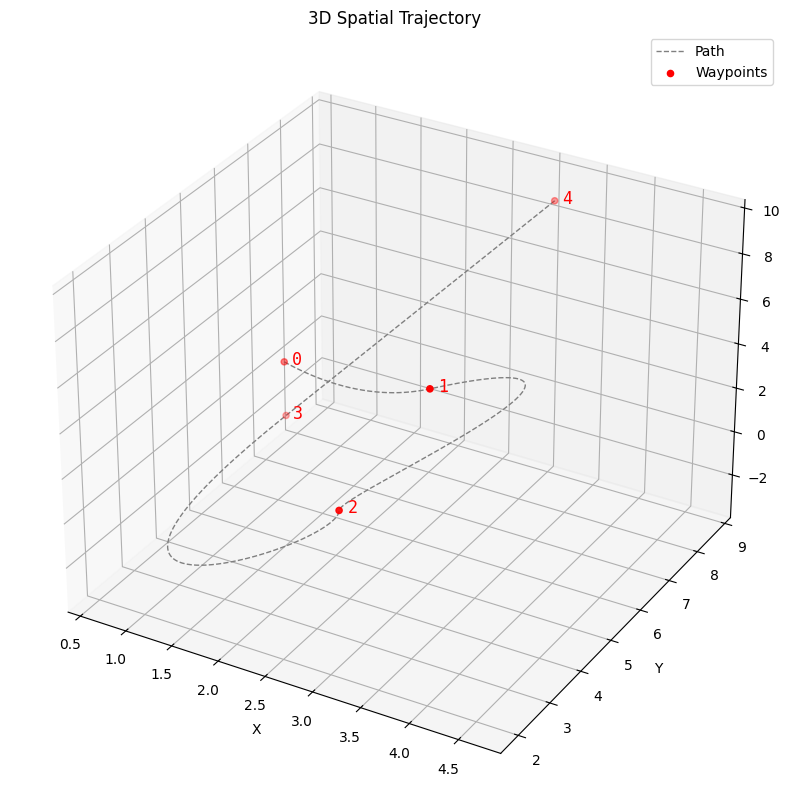

In [10]:
n_points = 5
times = np.arange(n_points, dtype=np.float64)
waypoints = np.random.rand(n_points, 3) * 10

traj = PolynomialTrajectoryND(waypoints, times)
fig = visualize_spatial_trajectory(traj)
plt.show()